# imports

In [7]:
import sys
sys.path.append('../')

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch

from NDNT.utils import imagesc   # because I'm lazy
import ColorDataUtils.mattplotlib as mplt
from ColorDataUtils.multidata_utils import MultiExperiment

class Model:
    def __init__(self, ndn_model, LLs):
        self.ndn = ndn_model
        self.LLs = LLs
from models import iter_core, cnn_core

device = torch.device("cuda:1")

datadir = '/home/dbutts/ColorV1/Data/'
dirname = '/home/dbutts/ColorV1/CLRworkspace/'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Iter Core

## plot LGN filters

0.028281411


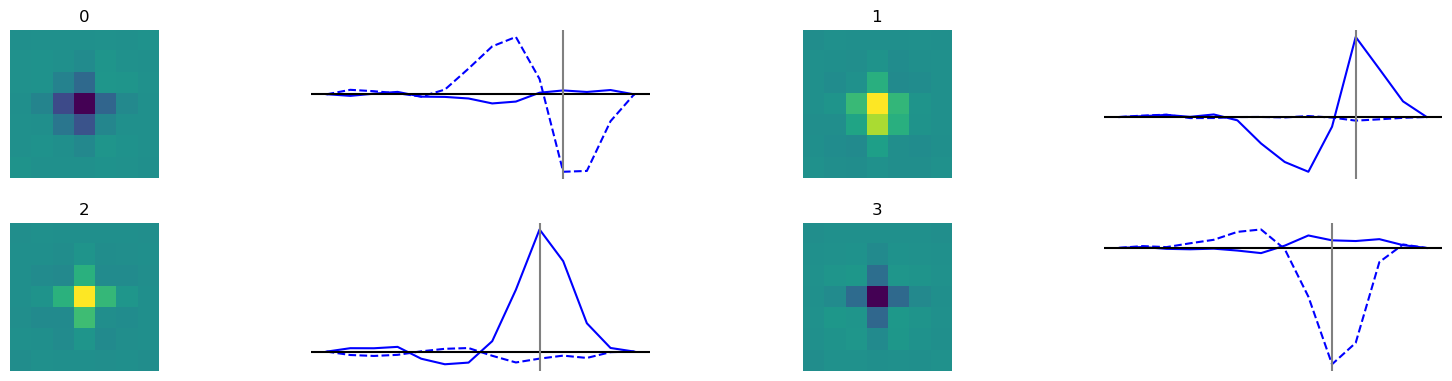

In [8]:
print(np.mean(iter_core.LLs))
iter_core.ndn_model.plot_filters()

## plot proj filters

In [9]:
iter_core.ndn_model.networks[0].layers[1].get_weights().shape

(4, 15, 15, 45)

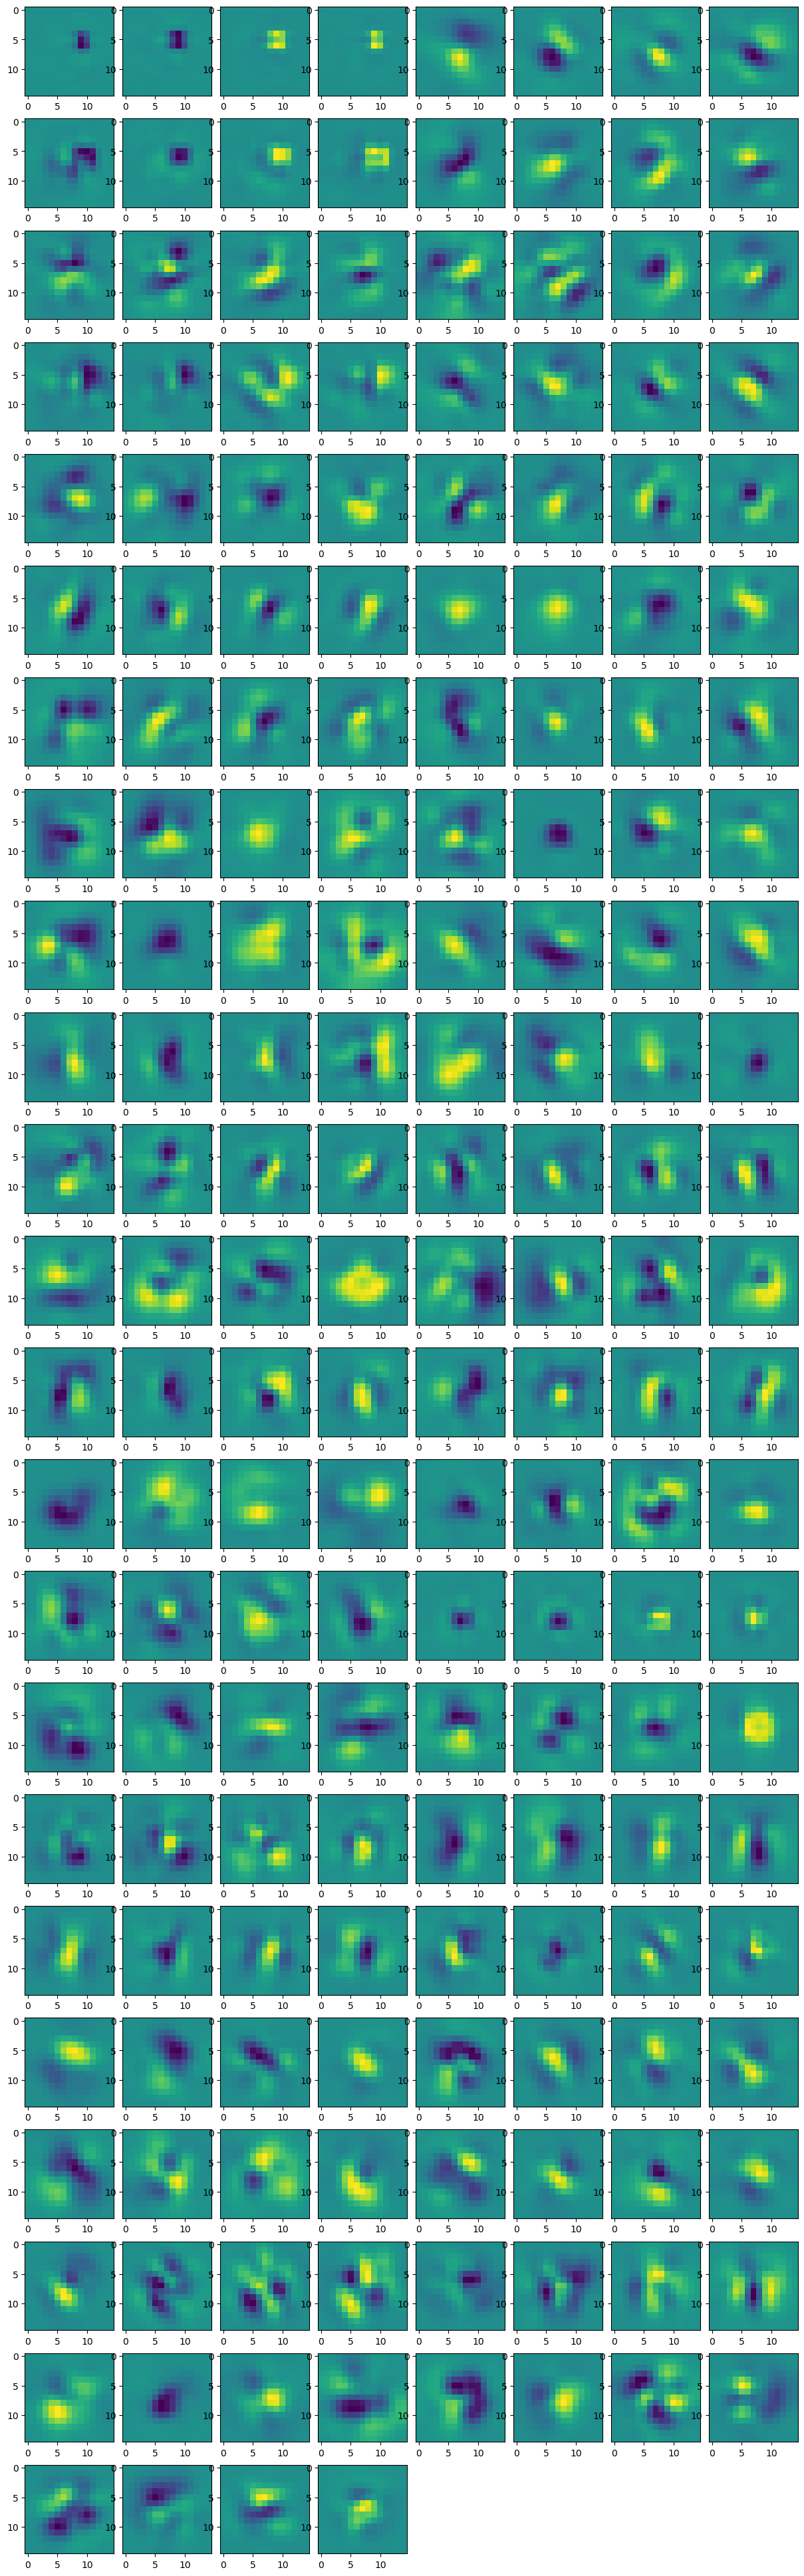

In [10]:
fig = plt.figure(figsize=(15,50))
grid = matplotlib.gridspec.GridSpec(23, 8, wspace=0.1, hspace=0.1)
for idx in range(45*4):
    i,j = np.unravel_index(idx,(45,4)) # layer position
    row,col = np.unravel_index(idx,(23,8)) # plot position
    ax = plt.subplot(grid[row,col])
    proj_filter = iter_core.ndn_model.networks[0].layers[1].get_weights()[j,:,:,i].reshape((15,15))
    imagesc(proj_filter, ax=ax, cmap='viridis')

# CNN Core

## plot LGN filters

0.028281411


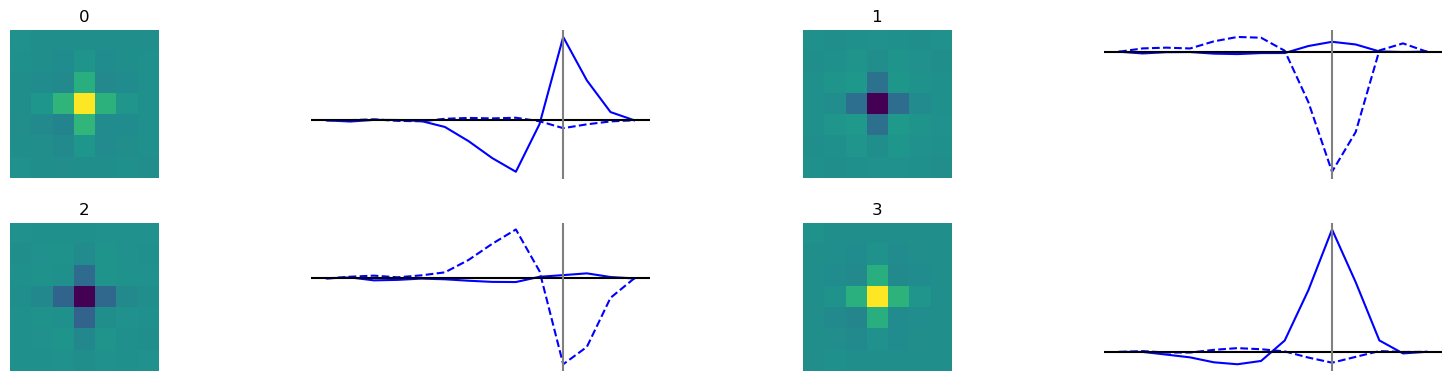

In [11]:
print(np.mean(iter_core.LLs))
cnn_core.ndn_model.plot_filters()

## plot proj filters

In [12]:
cnn_core.ndn_model.networks[0].layers[1].get_weights().shape

(4, 15, 15, 45)

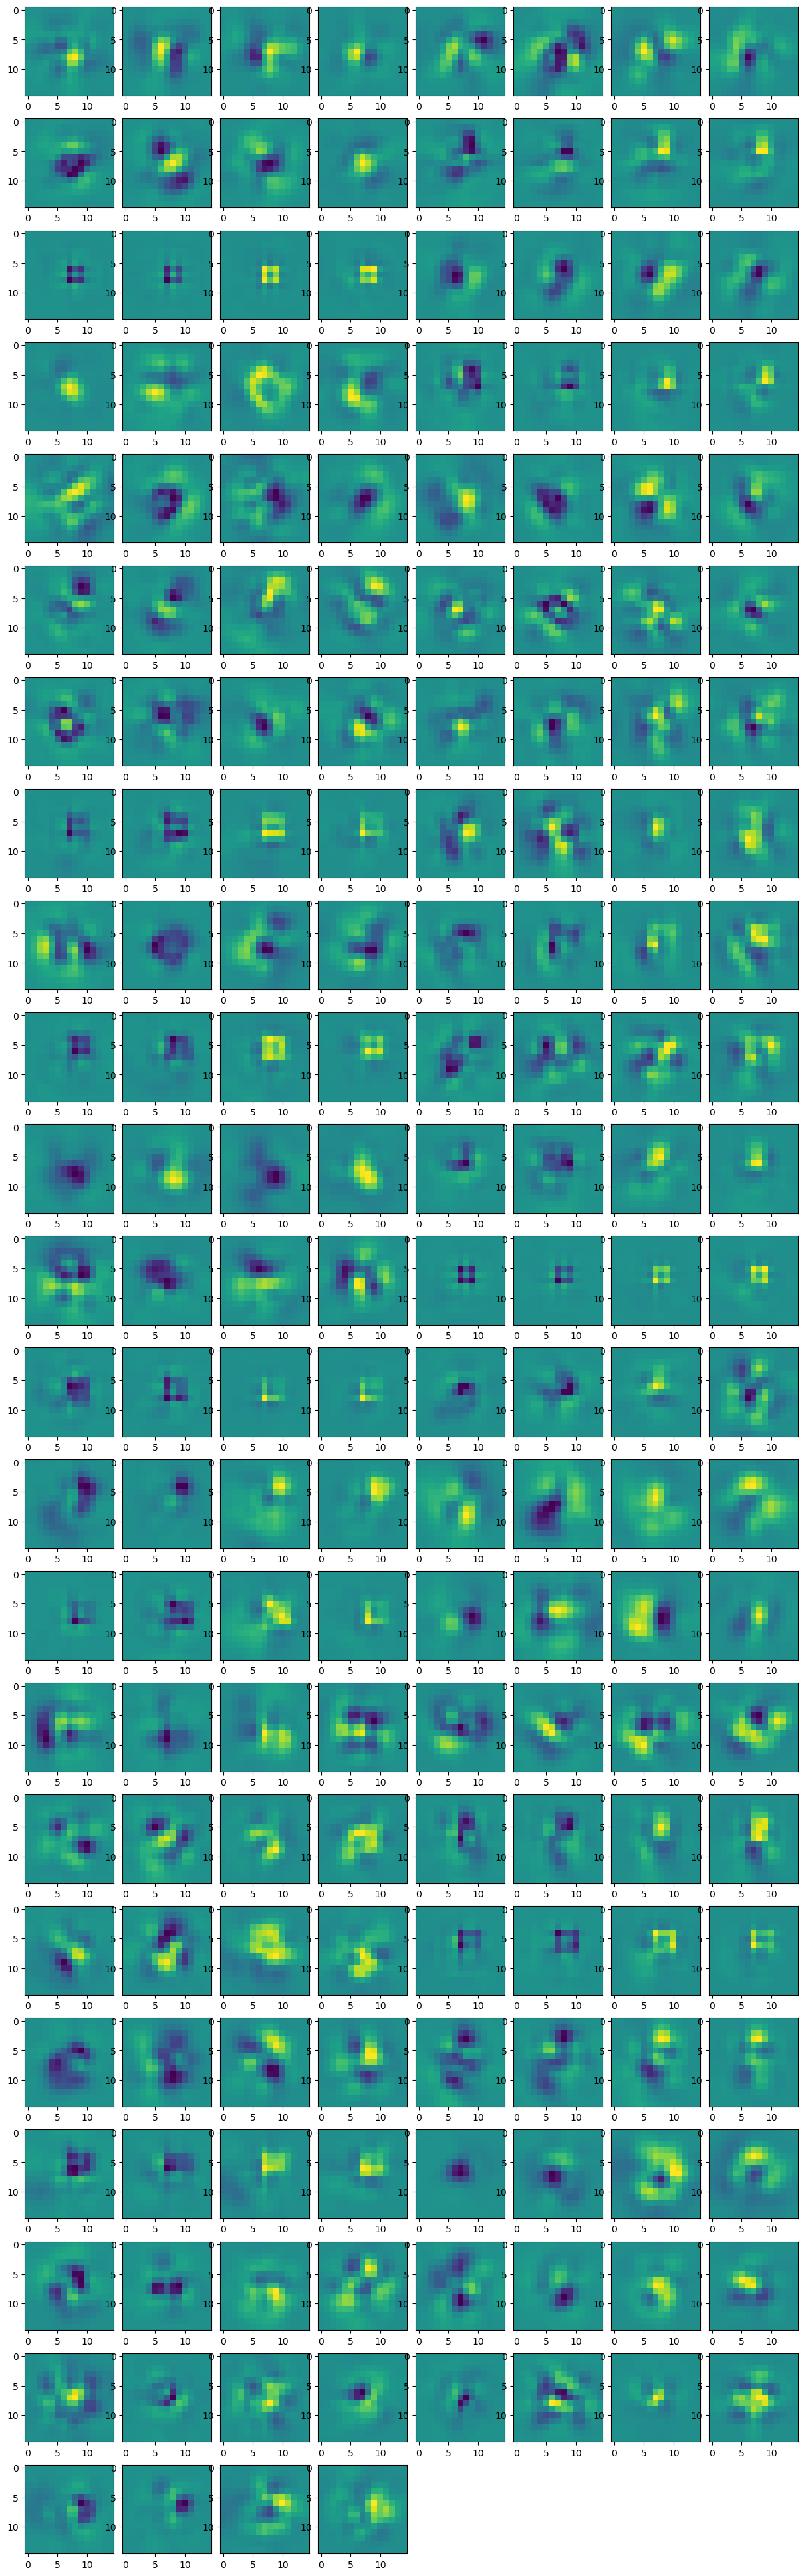

In [15]:
fig = plt.figure(figsize=(15,50))
grid = matplotlib.gridspec.GridSpec(23, 8, wspace=0.1, hspace=0.1)
for idx in range(45*4):
    i,j = np.unravel_index(idx,(45,4)) # layer position
    row,col = np.unravel_index(idx,(23,8)) # plot position
    ax = plt.subplot(grid[row,col])
    proj_filter = cnn_core.ndn_model.networks[0].layers[1].get_weights()[j,:,:,i].reshape((15,15))
    imagesc(proj_filter, ax=ax, cmap='viridis')

# cluster the proj filters

In [41]:
from copy import deepcopy
# iter proj_filters
proj_filters = deepcopy(iter_core.ndn_model.networks[0].layers[1].get_weights())
# CNN proj_filters
#proj_filters = deepcopy(cnn_core.ndn_model.networks[0].layers[1].get_weights())
print(proj_filters.shape)
proj_filters = np.swapaxes(proj_filters, 3,1)
proj_filters = np.swapaxes(proj_filters, 3,2)
proj_filters = np.reshape(proj_filters, (
    proj_filters.shape[0]*proj_filters.shape[1],
    proj_filters.shape[2]*proj_filters.shape[3]))
    #proj_filters.shape[2],proj_filters.shape[3]))
print(proj_filters.shape)

(4, 15, 15, 45)
(180, 225)


## UMAP clustering

In [89]:
import hdbscan
import seaborn as sns
hdbscan.dist_metrics.METRIC_MAPPING.keys()

dict_keys(['euclidean', 'l2', 'minkowski', 'p', 'manhattan', 'cityblock', 'l1', 'chebyshev', 'infinity', 'seuclidean', 'mahalanobis', 'wminkowski', 'hamming', 'canberra', 'braycurtis', 'matching', 'jaccard', 'dice', 'kulsinski', 'rogerstanimoto', 'russellrao', 'sokalmichener', 'sokalsneath', 'haversine', 'cosine', 'arccos', 'pyfunc'])

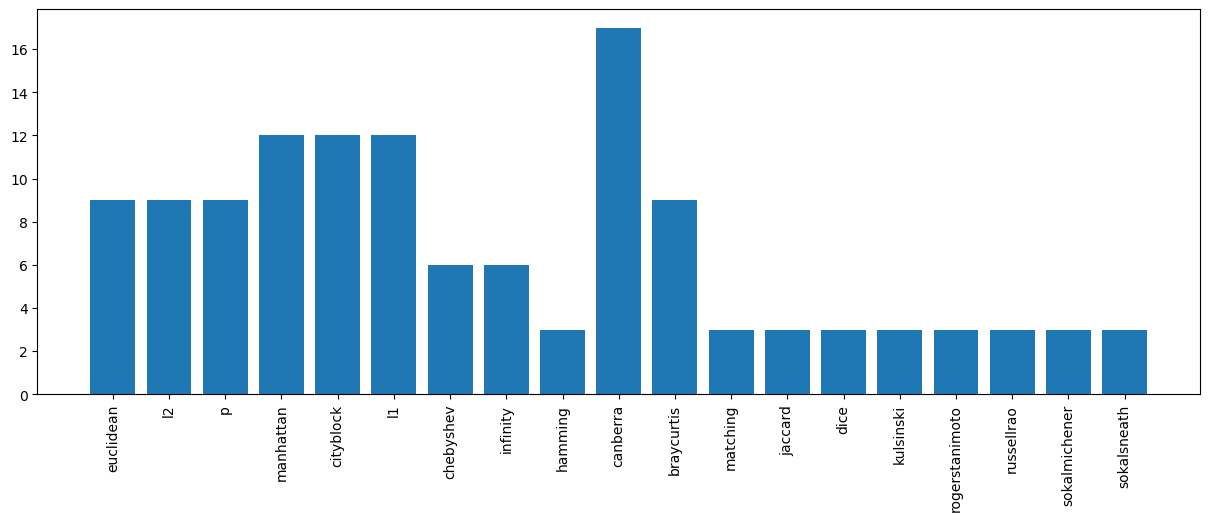

In [90]:
cluster_metrics = []
cluster_counts = []
for metric in hdbscan.dist_metrics.METRIC_MAPPING.keys():
    #print(metric)
    try:
        clusterer = hdbscan.HDBSCAN(min_cluster_size=2,
                                    metric=metric,
                                    prediction_data=True)
        clusterer.fit(proj_filters)

        soft_clusters = hdbscan.all_points_membership_vectors(clusterer)
        color_palette = sns.color_palette('Paired', 12)
        cluster_colors = [color_palette[np.argmax(x)]
                          for x in soft_clusters]
        
        cluster_metrics.append(metric)
        cluster_counts.append(len(np.unique(cluster_colors)))
        
        # for label in np.unique(clusterer.labels_):
        #     cluster_size = len(proj_filters[clusterer.labels_==label])
        #     print('cluster {} has {} filters'.format(label, cluster_size))
        # print()
    except(TypeError, ValueError) as e:
        #print(e)
        continue

# plot the sizes as a bar plot
fig = plt.figure(figsize=(15,5))
plt.bar(cluster_metrics, cluster_counts)
# rotate the xticks so they are readable
plt.xticks(rotation=90)
plt.show()

In [93]:
# display the filters with UMAP
# import umap
# reducer = umap.UMAP(n_neighbors=10, min_dist=0.1, metric='correlation')
# embedding = reducer.fit_transform(proj_filters)
# 
# # plot the embedding
# fig = plt.figure(figsize=(15,8))
# plt.scatter(embedding[:,0], embedding[:,1], s=10, c=clusterer.labels_, cmap='Spectral')
# plt.show()

clusterer = hdbscan.HDBSCAN(min_cluster_size=2,
                             metric='braycurtis',
                             prediction_data=True)
clusterer.fit(proj_filters)

soft_clusters = hdbscan.all_points_membership_vectors(clusterer)
color_palette = sns.color_palette('Paired', 16)
cluster_colors = [color_palette[np.argmax(x)]
                  for x in soft_clusters]

# plot clusters
for label in np.unique(cluster_colors):
    if label == -1:
        continue
    cluster_size = len(proj_filters[cluster_colors==label])
    print('cluster {} has {} filters'.format(label, cluster_size))
    fig = plt.figure(figsize=(15,10))
    grid = matplotlib.gridspec.GridSpec(cluster_size//8+1, 8, wspace=0.1, hspace=0.1)
    for idx in range(cluster_size):
        i,j = np.unravel_index(idx,(cluster_size//8+1,8)) # layer position
        ax = plt.subplot(grid[i,j])
        proj_filter = proj_filters[cluster_colors==label][idx].reshape((15,15))
        imagesc(proj_filter, ax=ax, cmap='viridis')
    plt.show()


IndexError: boolean index did not match indexed array along dimension 1; dimension is 225 but corresponding boolean dimension is 3

## hierarchical clustering (BAD)

In [ ]:
# class _Leaf(object):
#     def __init__(self, filter):
#         self.filter = filter
# 
# class _Cluster(object):
#     def __init__(self, distance, children):
#         self.distance = distance
#         self.children = children
#         self.filters = []
# 
#     def get_filters(self):
#         # populate the filters array if it is empty
#         if len(self.filters) == 0:
#             for child in self.children:
#                 if isinstance(child, _Leaf):
#                     self.filters.append(child.filter)
#                 else:
#                     self.filters.extend(child.get_filters())
#         return self.filters
# 
# 
# # create a proper tree structure,
# # where each node has the average distance of its children
# def convert_to_tree(pairs, filters):
#     leaves = {}
#     clusters = {}
# 
#     for i, row in enumerate(pairs):
#         if row[0] < len(filters):
#             # if it is an original point read it from the centers array
#             a = filters[int(row[0])]
#             a = _Leaf(a)
#             leaves[row[0]] = a
#         else:
#             # other wise read the cluster that has been created
#             a = clusters[int(row[0])]
# 
#         if row[1] < len(filters):
#             b = filters[int(row[1])]
#             b = _Leaf(b)
#             leaves[row[1]] = b
#         else:
#             b = clusters[int(row[1])]
# 
#         # set a and b as children of the new node
#         distance = row[2]
#         cluster = _Cluster(distance, children=[a, b])
# 
#         clusters[1 + i + len(pairs)] = cluster
#     return clusters
# from scipy.cluster import hierarchy
# # cluster the proj_filters
# 
# # make a distance matrix between the neurons based on their weights
# dists = np.zeros((proj_filters.shape[0], proj_filters.shape[0]))
# for i in range(proj_filters.shape[0]):
#     for j in range(proj_filters.shape[0]):
#         dists[i,j] = np.corrcoef(proj_filters[i], proj_filters[j])[0,1]
# 
# Z = hierarchy.linkage(dists, 'single')
# fig = plt.figure(figsize=(25, 10))
# dn = hierarchy.dendrogram(Z)
# 
# clusters = convert_to_tree(Z, proj_filters)
# 
# for i,cluster in enumerate(clusters.values()):
#     num_filters = len(cluster.get_filters())
#     num_rows = num_filters//8 + 1
#     num_cols = min(num_filters, 8)
#     fig = plt.figure(figsize=(10,10))
#     grid = matplotlib.gridspec.GridSpec(nrows=num_rows,
#                                         ncols=num_cols)
#     for j, filter in enumerate(cluster.get_filters()):
#         print(filter.shape)
#         row,col = np.unravel_index(j, (num_rows, num_cols))
#         ax = plt.subplot(grid[row,col])
#         imagesc(filter, ax=ax)
#     plt.show()